# Imports

In [ ]:
# ==============================================================================
# Imports
# ==============================================================================
import os
import time
IS_COLAB = any(var.startswith("COLAB_") for var in os.environ)

if IS_COLAB:
  print("Running in Google Colab...")
  os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
  %pip install pytorch-msssim --no-deps -q
  %pip install wandb -qU

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from pytorch_msssim import ssim
import numpy as np

# Image Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Metrics and Evaluation
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from skimage import measure

# Datasets and Logging
import kagglehub
import wandb

Running in Google Colab...


# Configuration

In [ ]:

# ==============================================================================
# Globals (Configuration)
# ==============================================================================
# General configurations
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 71
TRAIN_MODEL = False #true if we want to train, false if we only want to do inference
torch.manual_seed(SEED)
np.random.seed(SEED)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True
else:
    torch.backends.cudnn.enabled = False

# Dataset paths (placeholders - replace with actual paths)

BASE_PATH = ''
MVTEC_DATA_DIR = ''
BTAD_DATA_DIR = ''
MODEL_SAVE_DIR = ''
DATASET_DIR = ''

NUM_WORKERS_PARAM = dict()

# wandb login
wandb.login()

if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/'
    MODEL_SAVE_DIR = os.path.join(BASE_PATH, 'trained_models')
    DATASET_DIR = os.path.join(BASE_PATH, 'datasets')
    NUM_WORKERS_PARAM = {
        'num_workers': 2
    }
    MVTEC_DATA_DIR = os.path.join(DATASET_DIR, 'mvtec')
    BTAD_DATA_DIR = os.path.join(DATASET_DIR, 'btad')

else:
    BASE_PATH = os.path.dirname(os.curdir)
    MODEL_SAVE_DIR = os.path.join(BASE_PATH, 'trained_models')
    DATASET_DIR = os.path.join(BASE_PATH, 'datasets')
    NUM_WORKERS_PARAM = {
        'num_workers': 0
    }
    # Download MVTEC dataset
    MVTEC_DATA_DIR = kagglehub.dataset_download("ipythonx/mvtec-ad", force_download=False)
    # Download BTAD dataset
    BTAD_DATA_DIR = kagglehub.dataset_download("thtuan/btad-beantech-anomaly-detection", force_download=False)

if not os.path.exists(MODEL_SAVE_DIR):
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR, exist_ok=True)

print("BASE_PATH: ", BASE_PATH)
print("MODEL_SAVE_DIR: ", MODEL_SAVE_DIR)
print("DATASET_DIR: ", DATASET_DIR) #TODO implement a function to download the datasets if they are not present, and use the cached ones.




print("PATH TO DATASETS: ")
print("MVTEC: ", end='') #https://www.kaggle.com/datasets/ipythonx/mvtec-ad
print(MVTEC_DATA_DIR)
print("BTAD: ", end='') #https://www.kaggle.com/datasets/thtuan/btad-beantech-anomaly-detection
print(BTAD_DATA_DIR)

# Model configurations
IMG_SIZE = 256  # (co 512 saturo la A100) Target image size (VT-ADL used 512, but 256 is common for ViT)
PATCH_SIZE = 16 # Patch size for ViT
IN_CHANNELS = 3 # Input image channels (RGB)
EMBED_DIM = 768 # Embedding dimension for ViT
NUM_HEADS =  4 # Number of attention heads
NUM_LAYERS = 4 # Number of transformer layers (encoder blocks)
MLP_RATIO = 2.0 #4.0 # Ratio for MLP hidden dimension
DROPOUT_RATE = 0.0 # 0.1 # Dropout rate (VT-ADL paper mentioned not using dropout for GMDN stability)
                   # For DyT paper, dropout is often part of standard Transformer blocks.
                   # Let's make it configurable. Set to 0.0 if not desired.

# Training configurations
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
NUM_GAUSSIANS = 100 # Number of Gaussian components for GMDN (VT-ADL used 150)
NUM_EPOCHS = 1 # (VT-ADL used 400 epochs)
WEIGHT_DECAY = 10e-4
LAMBDA_MSE = 5.0 # Weight for MSE loss (VT-ADL used 5.0)
LAMBDA_SSIM = 0.5 # Weight for SSIM loss (VT-ADL used 0.5)
LAMBDA_GMDN = 1.0 # Weight for GMDN loss (VT-ADL used -1 for -LL)

# DyT specific
DYT_INIT_A = 0.5

# General Configuration
USING_DYT = True      # False if using Normalization Layer
USING_MVTEC = True    # False if using BTAD
CONF_STR = "DyT" if USING_DYT else "LayerNorm"
DATASET_STR = "MVTEC" if USING_MVTEC else "BTAD"
DATASET_CAT_STR = "bottle" if USING_MVTEC else "01"

# Model Comparison
COMPARE_MODELS = False  # True if you want to compare models
DYT_MODEL_NAME_MVTEC = ""
LN_MODEL_NAME_MVTEC = "newmodel_name"
DYT_MODEL_NAME_BTAD = ""
LN_MODEL_NAME_BTAD = "newmodel_name"



wandb: Currently logged in as: onogab (onogab-sapienza) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_PATH:  /content/drive/MyDrive/Colab Notebooks/Computer Vision/
MODEL_SAVE_DIR:  /content/drive/MyDrive/Colab Notebooks/Computer Vision/trained_models
DATASET_DIR:  /content/drive/MyDrive/Colab Notebooks/Computer Vision/datasets
PATH TO DATASETS: 
MVTEC: /content/drive/MyDrive/Colab Notebooks/Computer Vision/datasets/mvtec
BTAD: /content/drive/MyDrive/Colab Notebooks/Computer Vision/datasets/btad


ASSIGNED EXPERIMENT_NAME:  charmed-eon-10


# Utils

In [ ]:
# ==============================================================================
# Utils - Helper functions
# ==============================================================================
class Utils:
    @staticmethod
    def show_image(tensor_img, title=""):
        """Displays a tensor image."""
        if tensor_img.is_cuda:
            tensor_img = tensor_img.cpu()
        img = tensor_img.detach().squeeze().permute(1, 2, 0).numpy()
        # Denormalize if necessary, or clip to [0, 1]
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
        wandb.summary[title] = wandb.Image(plt)
        plt.show()

    @staticmethod
    def save_checkpoint(state, filename="checkpoint.pth.tar"):
        """Saves checkpoint."""
        print("=> Saving checkpoint")
        torch.save(state, filename)

    @staticmethod
    def load_checkpoint(checkpoint_path, model, optimizer=None):
        """Loads checkpoint."""
        print("=> Loading checkpoint")
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['state_dict'])
        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer'])
        return checkpoint.get('epoch', 0)

    @staticmethod
    def calculate_ssim_loss(img1, img2, data_range=1.0, window_size=11):
        """
        Calculates 1 - SSIM as a loss.
        Higher SSIM (1.0) means higher similarity, so we use 1.0 - SSIM as the loss.

        Args:
            img1, img2: Input images (batches of tensors)
            data_range: Maximum value range of images (usually 1.0 or 255)
            window_size: Size of the gaussian filter window

        Returns:
            A scalar loss value (lower is better)
        """
        if img1.device != img2.device:
            img2 = img2.to(img1.device)

        # Ensure input dimensions are correct (N,C,H,W format)
        if img1.dim() == 3:
            img1 = img1.unsqueeze(0)
        if img2.dim() == 3:
            img2 = img2.unsqueeze(0)

        if img1.shape != img2.shape:
            raise ValueError(f"Input images must have the same shape but got {img1.shape} and {img2.shape}")

        # Calculate SSIM (returns value between 0 and 1, where 1 is perfect similarity)
        ssim_value = ssim(
            img1,
            img2,
            data_range=data_range,
            size_average=True,  # Return a scalar
            win_size=window_size,  # Gaussian filter size
            K=(0.01, 0.03)  # Default constants
        )

        # Convert to loss (lower is better)
        return 1.0 - ssim_value

    @staticmethod
    def get_transforms(img_size):
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            # Add normalization if your model expects it (e.g., ImageNet mean/std)
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    @staticmethod
    def plot_loss(losses, n_epochs, title):
        """Plots the training loss over epochs."""
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, n_epochs + 1), losses)
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    @staticmethod
    def log_wandb_classification_report(y_true, y_pred, class_names):
        """
        Logs classification report to wandb.
        Args:
            y_true: True labels
            y_pred: Predicted labels
            class_names: List of class names
        """
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        for metric, value in report.items():
            wandb.summary[metric] = value

    @staticmethod
    def visualize_model_results(results):
        """
        Create visualizations of model evaluation results and return the plot objects.
        
        Parameters:
        -----------
        results : dict
            Dictionary where keys are model names and values are dictionaries of metrics.
            Each model's dictionary should contain metrics and 'evaluation_time'.
            
        Returns:
        --------
        matplotlib.figure.Figure
            The figure object containing the visualization
        """
        # Set a nice aesthetic style
        sns.set_style("whitegrid")
        
        # Extract model names and metrics
        model_names = list(results.keys())
        metrics = {key for model_data in results.values() for key in model_data.keys()}
        metrics = list(metrics - {'evaluation_time'})  # Get all metrics except evaluation time
        
        # Create subplots: one for eval time, one for metrics
        fig, axes = plt.subplots(2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [1, 2]})
        
        # 1. Plot evaluation time
        eval_times = [results[model]['evaluation_time'] for model in model_names]
        ax1 = axes[0]
        bars = ax1.bar(model_names, eval_times, color=sns.color_palette("viridis", len(model_names)))
        ax1.set_title('Model Evaluation Time', fontsize=16)
        ax1.set_ylabel('Time (seconds)', fontsize=14)
        ax1.set_xlabel('Models', fontsize=14)
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.2f}s', ha='center', va='bottom')
        
        # 2. Plot performance metrics
        ax2 = axes[1]
        x = np.arange(len(model_names))
        bar_width = 0.8 / len(metrics)
        offset = np.linspace(-0.4 + bar_width/2, 0.4 - bar_width/2, len(metrics))
        
        for i, metric in enumerate(metrics):
            values = [results[model].get(metric, 0) for model in model_names]
            bars = ax2.bar(x + offset[i], values, bar_width, 
                           label=metric, alpha=0.8,
                           color=sns.color_palette("muted", len(metrics))[i])
            
            # Add value labels on bars
            for j, bar in enumerate(bars):
                height = bar.get_height()
                if height > 0.01:  # Only show values that are visible
                    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{height:.3f}', ha='center', va='bottom', fontsize=8)
        
        ax2.set_title('Model Performance Metrics', fontsize=16)
        ax2.set_ylabel('Score', fontsize=14)
        ax2.set_xlabel('Models', fontsize=14)
        ax2.set_xticks(x)
        ax2.set_xticklabels(model_names, rotation=45, ha='right')
        ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
        ax2.set_ylim(0, 1.0)  # Assuming metrics are between 0 and 1
        
        # Identify MVTec and BTAD models for annotations
        mvtec_models = [model for model in model_names if "mvtec" in model]
        btad_models = [model for model in model_names if "mvtec" not in model]
        
        # Add dataset annotations if there are clearly separated models
        if mvtec_models and btad_models:
            mvtec_indices = [model_names.index(model) for model in mvtec_models]
            btad_indices = [model_names.index(model) for model in btad_models]
            
            if min(mvtec_indices) > max(btad_indices) or max(mvtec_indices) < min(btad_indices):
                # Models are grouped by dataset - we can add dividers
                divider_x = (max(mvtec_indices) + min(btad_indices))/2 if min(mvtec_indices) > max(btad_indices) else (max(btad_indices) + min(mvtec_indices))/2
                for ax in axes:
                    ax.axvline(x=divider_x - 0.5, color='gray', linestyle='--', alpha=0.5)
                    
                    if min(mvtec_indices) < min(btad_indices):
                        ax.text(np.mean(mvtec_indices), ax.get_ylim()[1]*0.95, "MVTec Models", ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
                        ax.text(np.mean(btad_indices), ax.get_ylim()[1]*0.95, "BTAD Models", ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
                    else:
                        ax.text(np.mean(btad_indices), ax.get_ylim()[1]*0.95, "BTAD Models", ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
                        ax.text(np.mean(mvtec_indices), ax.get_ylim()[1]*0.95, "MVTec Models", ha='center', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        fig.suptitle('Model Evaluation Results Comparison', fontsize=18, y=0.98)
        plt.subplots_adjust(top=0.9, bottom=0.15)
        
        return fig


# Dataset Loading

In [4]:
# ==============================================================================
# Data - Dataset loading and preprocessing
# ==============================================================================
class BaseAnomalyDataset(Dataset):
    """Base class for anomaly detection datasets."""

    def __init__(self, transform=None, img_size=256):
        """
        Initialize the base anomaly dataset.

        Args:
            transform (callable, optional): Optional transform to be applied on a sample
            img_size (int): Target image size
        """
        self.transform = transform if transform else Utils.get_transforms(img_size)
        self.image_paths = []
        self.mask_paths = []

    def __len__(self):
        return len(self.image_paths)

    def _load_mask(self, mask_path, image_shape):
        """
        Load and process a mask image.

        Args:
            mask_path (str): Path to the mask image
            image_shape (tuple): Shape of the corresponding image

        Returns:
            torch.Tensor: Processed mask tensor
        """
        if mask_path is None:
            # Create an empty mask
            mask = torch.zeros((1, image_shape[1], image_shape[2]))
            return mask

        try:
            mask_pil = Image.open(mask_path).convert("L")  # Grayscale mask
            mask_pil = transforms.Resize((image_shape[1], image_shape[2]))(mask_pil)
            mask = transforms.ToTensor()(mask_pil)
            mask = (mask > 0.5).float()  # Binarize
            return mask
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            # Return empty mask on error
            return torch.zeros((1, image_shape[1], image_shape[2]))

In [5]:
class MVTecDataset(BaseAnomalyDataset):
    """Dataset class for MVTec Anomaly Detection dataset."""

    def __init__(self, data_dir, category, split="train", transform=None, img_size=256):
        """
        Initialize MVTec dataset.

        Args:
            data_dir (str): Path to MVTec dataset
            category (str): Category name (e.g., 'bottle', 'cable')
            split (str): 'train' or 'test'
            transform (callable, optional): Optional transform
            img_size (int): Target image size
        """
        super().__init__(transform, img_size)
        self.data_dir = data_dir
        self.category = category
        self.split = split.lower()

        self._load_data()

    def _load_data(self):
        """Load data paths based on dataset structure."""
        category_path = os.path.join(self.data_dir, self.category)

        if self.split == "train":
            # Training set contains only 'good' (normal) images
            image_folder = os.path.join(category_path, "train", "good")

            if os.path.exists(image_folder):
                for img_name in os.listdir(image_folder):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
                        self.image_paths.append(os.path.join(image_folder, img_name))
                        self.mask_paths.append(None)  # No masks for normal training images
            else:
                raise ValueError(f"Training folder not found: {image_folder}")

        elif self.split == "test":
            # Test set contains 'good' and anomalous images
            image_folder = os.path.join(category_path, "test")
            mask_folder = os.path.join(category_path, "ground_truth")

            if not os.path.exists(image_folder):
                raise ValueError(f"Test folder not found: {image_folder}")

            # Iterate through subfolders (e.g., good, broken_large, etc.)
            for subfolder_name in os.listdir(image_folder):
                subfolder_path = os.path.join(image_folder, subfolder_name)
                if os.path.isdir(subfolder_path):
                    for img_name in os.listdir(subfolder_path):
                        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
                            self.image_paths.append(os.path.join(subfolder_path, img_name))

                            if subfolder_name != "good":  # Anomalous images have masks
                                mask_name = img_name.split('.')[0] + "_mask.png"
                                mask_path = os.path.join(mask_folder, subfolder_name, mask_name)
                                self.mask_paths.append(mask_path)
                            else:
                                self.mask_paths.append(None)
        else:
            raise ValueError(f"Split '{self.split}' not supported. Use 'train' or 'test'.")

    def __getitem__(self, idx):
        """Get a sample from the dataset."""
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # For training, only images are needed
        if self.split == "train":
            return image

        # For testing, return image, mask, and label
        mask_path = self.mask_paths[idx]
        mask = self._load_mask(mask_path, image.shape)

        # Image is anomalous if it has a mask
        img_label = 1 if mask_path is not None else 0

        return image, mask, img_label


In [6]:
class BTADDataset(BaseAnomalyDataset):
    """Dataset class for BTAD Anomaly Detection dataset."""

    def __init__(self, data_dir, category, split="train", transform=None, img_size=256):
        """
        Initialize BTAD dataset.

        Args:
            data_dir (str): Path to BTAD dataset
            category (str): Category name (e.g., '01', '02', '03')
            split (str): 'train' or 'test'
            transform (callable, optional): Optional transform
            img_size (int): Target image size
        """
        super().__init__(transform, img_size)
        self.data_dir = data_dir
        self.category = category
        self.split = split.lower()

        self._load_data()

    def _load_data(self):
        """Load data paths based on dataset structure."""
        product_path = os.path.join(self.data_dir, self.category)

        if self.split == "train":
            # Training set contains only normal ('ok') images
            image_folder = os.path.join(product_path, "train", "ok")

            if os.path.exists(image_folder):
                for img_name in os.listdir(image_folder):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(image_folder, img_name))
                        self.mask_paths.append(None)  # No masks for normal training images
            else:
                raise ValueError(f"Training folder not found: {image_folder}")

        elif self.split == "test":
            # Test set contains normal ('ok') and anomalous ('ko') images
            image_folder_ok = os.path.join(product_path, "test", "ok")
            image_folder_ko = os.path.join(product_path, "test", "ko")
            mask_folder_ko = os.path.join(product_path, "test", "ko_mask")

            # Add normal images
            if os.path.exists(image_folder_ok):
                for img_name in os.listdir(image_folder_ok):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(image_folder_ok, img_name))
                        self.mask_paths.append(None)  # No masks for normal images

            # Add anomalous images
            if os.path.exists(image_folder_ko):
                for img_name in os.listdir(image_folder_ko):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(image_folder_ko, img_name))

                        # Mask path is the same as image name in ko_mask folder
                        mask_path = os.path.join(mask_folder_ko, img_name)
                        self.mask_paths.append(mask_path)

            if len(self.image_paths) == 0:
                raise ValueError(f"No test images found in {image_folder_ok} or {image_folder_ko}")
        else:
            raise ValueError(f"Split '{self.split}' not supported. Use 'train' or 'test'.")

    def __getitem__(self, idx):
        """Get a sample from the dataset."""
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # For training, only images are needed
        if self.split == "train":
            return image

        # For testing, return image, mask, and label
        mask_path = self.mask_paths[idx]
        mask = self._load_mask(mask_path, image.shape)

        # Image is anomalous if it has a mask
        img_label = 1 if mask_path is not None else 0

        return image, mask, img_label

# Network Components

In [7]:
# ==============================================================================
# Network - Core model components
# ==============================================================================

## DyT (Dynamic Tanh)

In [8]:
class DyT(nn.Module):
    """ Dynamic Tanh Layer """
    def __init__(self, dim, init_a=DYT_INIT_A):
        super().__init__()
        self.alpha = nn.Parameter(torch.tensor(init_a, dtype=torch.float32))
        self.gamma = nn.Parameter(torch.ones(dim, dtype=torch.float32) * 0.9)
        self.beta = nn.Parameter(torch.zeros(dim, dtype=torch.float32))
        # To ensure gamma and beta can be broadcasted correctly with (B, N, D) input
        # they need to be shaped as (1, 1, D) or (D)
        # PyTorch handles (D) broadcasting to (B,N,D) if op is like self.gamma * tensor

    def forward(self, x):
        # x shape: (batch_size, num_patches, embed_dim)
        return self.gamma * torch.tanh(self.alpha * x) + self.beta

## Attention

In [9]:
class Attention(nn.Module):
    """ Multi-Head Self-Attention """
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape # Batch, NumPatches, Channels(Dimension)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

## MLP

In [10]:
class MLP(nn.Module):
    """ MLP block """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

## Transformer (Block)

In [11]:
class NormalizationFactory:
    """Factory class for creating normalization layers."""

    @staticmethod
    def create_norm_layer(norm_type, dim, dyt_init_a=0.5):
        """
        Create a normalization layer based on the specified type.

        Args:
            norm_type (str): Type of normalization ('layernorm' or 'dyt')
            dim (int): Dimension of the input features
            dyt_init_a (float): Initial alpha value for DyT

        Returns:
            nn.Module: Normalization layer

        Raises:
            ValueError: If norm_type is not supported
        """
        norm_type = norm_type.lower()

        if norm_type == 'layernorm':
            return nn.LayerNorm(dim)
        elif norm_type == 'dyt':
            return DyT(dim, init_a=dyt_init_a)
        else:
            raise ValueError(f"Unsupported normalization type: {norm_type}. Choose 'layernorm' or 'dyt'.")

In [12]:
class TransformerBlock(nn.Module):
    """ Transformer Encoder Block with flexible normalization """
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 act_layer=nn.GELU, norm_layer_type='layernorm', dyt_init_a=0.5):
        super().__init__()
        # Use factory to create normalization layers
        self.norm1 = NormalizationFactory.create_norm_layer(norm_layer_type, dim, dyt_init_a)
        self.norm2 = NormalizationFactory.create_norm_layer(norm_layer_type, dim, dyt_init_a)

        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

## Patch Embedding

In [13]:
class PatchEmbedding(nn.Module):
    """ Image to Patch Embedding """
    def __init__(self, img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_chans=IN_CHANNELS, embed_dim=EMBED_DIM):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, \
            f"Input image size ({H}x{W}) doesn't match model ({self.img_size}x{self.img_size})."
        x = self.proj(x)  # B, embed_dim, H//patch_size, W//patch_size
        x = x.flatten(2)  # B, embed_dim, num_patches
        x = x.transpose(1, 2)  # B, num_patches, embed_dim
        return x

## ViT Encoder & Decoder

In [14]:
class ViTEncoder(nn.Module):
    """ Vision Transformer Encoder """
    def __init__(self, img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_chans=IN_CHANNELS,
                 embed_dim=EMBED_DIM, depth=NUM_LAYERS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
                 qkv_bias=True, drop_rate=DROPOUT_RATE, attn_drop_rate=DROPOUT_RATE,
                 norm_layer_type='layernorm', dyt_init_a=DYT_INIT_A):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) # Optional, not always used in reconstruction
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 0, embed_dim)) # +1 if cls_token is used
        self.pos_drop = nn.Dropout(p=drop_rate)

        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                drop=drop_rate, attn_drop=attn_drop_rate, norm_layer_type=norm_layer_type, dyt_init_a=dyt_init_a
            )
            for _ in range(depth)])

        # Final normalization layer (as in ViT, sometimes applied after blocks)
        if norm_layer_type.lower() == 'layernorm':
            self.norm = nn.LayerNorm(embed_dim)
        elif norm_layer_type.lower() == 'dyt':
            self.norm = DyT(embed_dim, init_a=dyt_init_a)
        else: # No final norm if not specified or if handled differently
            self.norm = nn.Identity()


    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x) # (B, num_patches, embed_dim)

        # cls_tokens = self.cls_token.expand(B, -1, -1) # If using CLS token
        # x = torch.cat((cls_tokens, x), dim=1) # If using CLS token

        x = x + self.pos_embed # Add positional embedding
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x) # Apply final normalization

        # Return all patch tokens for reconstruction/GMDN
        return x # (B, num_patches, embed_dim)

class Decoder(nn.Module):
    """ Convolutional Decoder for image reconstruction """
    def __init__(self, embed_dim=EMBED_DIM, patch_size=PATCH_SIZE, out_chans=IN_CHANNELS, img_size=IMG_SIZE):
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.num_patches_side = img_size // patch_size

        # This decoder structure is inspired by VT-ADL (5 transposed conv layers)
        # and common autoencoder decoders. Adjust channels and kernel sizes as needed.
        # It needs to upsample from (num_patches_side, num_patches_side) to (img_size, img_size)

        # Example: if img_size=256, patch_size=16, num_patches_side=16.
        # Input to first TransposedConv will be (B, embed_dim, num_patches_side, num_patches_side)

        # Channels for transposed convolutions. This is a common pattern.
        # Start from embed_dim, halve it progressively.
        decoder_channels = [embed_dim, embed_dim // 2, embed_dim // 4, embed_dim // 8, embed_dim // 16]

        self.decoder_layers = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, decoder_channels[1], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(decoder_channels[1]),
            nn.ReLU(True), # H/P * 2

            nn.ConvTranspose2d(decoder_channels[1], decoder_channels[2], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(decoder_channels[2]),
            nn.ReLU(True), # H/P * 4

            nn.ConvTranspose2d(decoder_channels[2], decoder_channels[3], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(decoder_channels[3]),
            nn.ReLU(True), # H/P * 8

            nn.ConvTranspose2d(decoder_channels[3], decoder_channels[4], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(decoder_channels[4]),
            nn.ReLU(True), # H/P * 16 -> This should be img_size if patch_size makes H/P * 16 = img_size
                           # E.g. if patch_size=16, this gives 16*16 = 256. Correct.
                           # If patch_size=32, this gives 8*16 = 128. Need one more layer or adjust strides/kernels.

            # Final layer to get to out_chans
            nn.ConvTranspose2d(decoder_channels[4], out_chans, kernel_size=3, stride=1, padding=1), # No stride 2 here, just adjust channels
            nn.Tanh() # To scale output to [-1, 1], or Sigmoid for [0, 1]
        )

    def forward(self, x):
        # x shape: (B, num_patches, embed_dim)
        B, N, D = x.shape
        # Reshape to (B, embed_dim, num_patches_side, num_patches_side)
        x = x.transpose(1, 2).reshape(B, D, self.num_patches_side, self.num_patches_side)
        x = self.decoder_layers(x)
        return x

## ViT Autoencoder

In [15]:
class ViTAutoencoder(nn.Module):
    """ ViT Encoder + Decoder for Anomaly Detection """
    def __init__(self, img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_chans=IN_CHANNELS,
                 embed_dim=EMBED_DIM, encoder_depth=NUM_LAYERS, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, qkv_bias=True, drop_rate=DROPOUT_RATE, attn_drop_rate=DROPOUT_RATE,
                 norm_layer_type='layernorm', dyt_init_a=DYT_INIT_A):
        super().__init__()
        self.encoder = ViTEncoder(img_size, patch_size, in_chans, embed_dim, encoder_depth,
                                  num_heads, mlp_ratio, qkv_bias, drop_rate, attn_drop_rate,
                                  norm_layer_type, dyt_init_a)
        self.decoder = Decoder(embed_dim, patch_size, in_chans, img_size)

    def forward(self, x):
        latent_features = self.encoder(x) # (B, num_patches, embed_dim)
        reconstructed_img = self.decoder(latent_features)
        return reconstructed_img, latent_features

## Gaussian Mixture Density Network

In [16]:
class GaussianMixtureDensityNetwork(nn.Module):
    """ GMDN head for anomaly localization (inspired by VT-ADL) """
    def __init__(self, feature_dim=EMBED_DIM, num_gaussians=NUM_GAUSSIANS): #VT-ADL used 150
        super().__init__()
        self.num_gaussians = num_gaussians
        self.feature_dim = feature_dim

        self.param_predictor = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 2), # Example intermediate layer
            nn.ReLU(),
            nn.Linear(feature_dim * 2, num_gaussians * (1 + feature_dim + feature_dim))
        )


        # Initialize the last layer with smaller weights for better convergence
        nn.init.xavier_normal_(self.param_predictor[-1].weight, gain=0.01)

        # Small constant to add for numerical stability
        self.eps = 1e-8

    def forward(self, patch_features):
        """
        Predict GMM parameters for each patch feature.

        Args:
            patch_features: Tensor of shape (B, N, D) where
                            B = batch size, N = num patches, D = feature dimension

        Returns:
            Tuple of (weights, means, std_devs) for the Gaussian components
        """
        B, N, D = patch_features.shape

        # Process each patch feature independently
        flat_features = patch_features.reshape(B * N, D)
        params = self.param_predictor(flat_features)  # (B*N, num_gaussians * (1+2D))

        # Reshape params
        params = params.reshape(B * N, self.num_gaussians, 1 + 2 * D)

        # Extract logits for weights, means, and log_std_devs
        logit_weights = params[..., 0]  # (B*N, num_gaussians)
        means = params[..., 1 : 1 + D]  # (B*N, num_gaussians, D)
        log_std_devs = params[..., 1 + D :]  # (B*N, num_gaussians, D)

        # Apply activations
        weights = F.softmax(logit_weights, dim=-1)  # (B*N, num_gaussians)

        # Clamp log_std_devs for numerical stability before exponentiation
        log_std_devs = torch.clamp(log_std_devs, min=-20, max=20)
        std_devs = torch.exp(log_std_devs)  # (B*N, num_gaussians, D)

        # Reshape back to (B, N, num_gaussians, ...)
        weights = weights.reshape(B, N, self.num_gaussians)
        means = means.reshape(B, N, self.num_gaussians, D)
        std_devs = std_devs.reshape(B, N, self.num_gaussians, D)

        return weights, means, std_devs

    def calculate_nll(self, patch_features, weights, means, std_devs, reduction='mean'):
        """
        Calculate negative log-likelihood for patch features given GMM parameters.
        Uses log-space calculations for numerical stability.

        Args:
            patch_features: (B, N, D) - feature vectors for each patch
            weights: (B, N, num_gaussians) - mixture weights
            means: (B, N, num_gaussians, D) - component means
            std_devs: (B, N, num_gaussians, D) - component standard deviations
            reduction: 'mean' to return scalar loss, 'none' to return per-patch loss

        Returns:
            NLL loss, either as mean or per-patch values
        """
        B, N, D = patch_features.shape

        # Expand patch_features to match GMM components: (B, N, 1, D)
        y = patch_features.unsqueeze(2)

        # Add small epsilon to std_devs for numerical stability
        std_devs = std_devs + self.eps

        # Calculate log probability for each Gaussian component in a numerically stable way
        # log N(y|μ,σ) = -0.5 * log(2π) - log(σ) - 0.5 * ((y - μ)/σ)²
        log_probs_gauss = -0.5 * np.log(2 * np.pi) - torch.log(std_devs) - \
                          0.5 * ((y - means) / std_devs)**2

        # Sum over feature dimension D -> (B, N, num_gaussians)
        log_probs_gauss = log_probs_gauss.sum(dim=-1)

        # Calculate log p(y|x) = log(Σᵢ wᵢ * N(y|μᵢ,σᵢ)) using the log-sum-exp trick
        # First add log(wᵢ) to each component's log probability
        log_weights = torch.log(weights + self.eps)
        weighted_log_probs = log_weights + log_probs_gauss

        # Use logsumexp for numerical stability
        log_likelihood_patch = torch.logsumexp(weighted_log_probs, dim=-1)  # (B, N)

        # Negative log likelihood (to minimize)
        nll = -log_likelihood_patch

        if reduction == 'mean':
            return nll.mean()  # Average NLL over all patches and batch
        elif reduction == 'none':
            return nll  # Return per-patch NLL (B, N)
        else:
            raise ValueError(f"Unknown reduction: {reduction}. Use 'mean' or 'none'.")

## (Final) Anomaly Detection Model

In [17]:
class ViTAnomalyModelWithGMDN(nn.Module):
    def __init__(self, img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_chans=IN_CHANNELS,
                 embed_dim=EMBED_DIM, encoder_depth=NUM_LAYERS, num_heads=NUM_HEADS,
                 mlp_ratio=MLP_RATIO, norm_layer_type='layernorm', dyt_init_a=DYT_INIT_A,
                 num_gaussians_gmdn=NUM_GAUSSIANS):
        super().__init__()
        self.autoencoder = ViTAutoencoder(
            img_size, patch_size, in_chans, embed_dim, encoder_depth, num_heads,
            mlp_ratio, norm_layer_type=norm_layer_type, dyt_init_a=dyt_init_a
        )
        self.gmdn_head = GaussianMixtureDensityNetwork(
            feature_dim=embed_dim, num_gaussians=num_gaussians_gmdn
        )

    def forward(self, x):
        reconstructed_img, latent_features = self.autoencoder(x)
        # latent_features shape: (B, num_patches, embed_dim)

        # add gaussian noise to latent features during training (Suggested by Claude)
        if self.training:
            noise = torch.randn_like(latent_features) * 0.2
            latent_features = latent_features + noise

        gmdn_weights, gmdn_means, gmdn_std_devs = self.gmdn_head(latent_features)

        return reconstructed_img, latent_features, gmdn_weights, gmdn_means, gmdn_std_devs

# Train

In [18]:
# ==============================================================================
# Train - Training loop and logic
# ==============================================================================
def train_one_epoch(model, dataloader, optimizer, epoch, total_epochs):
    model.train()
    total_loss = 0.0

    losses = list()

    for batch_idx, images in enumerate(dataloader):
        images = images.to(DEVICE) # Assuming training data is only normal images

        optimizer.zero_grad()

        # Forward pass
        if isinstance(model, ViTAnomalyModelWithGMDN):
            reconstructed_imgs, latent_features, g_weights, g_means, g_std_devs = model(images)
            loss_mse = F.mse_loss(reconstructed_imgs, images)
            loss_ssim = Utils.calculate_ssim_loss(reconstructed_imgs, images) # 1 - SSIM
            loss_gmdn = model.gmdn_head.calculate_nll(latent_features, g_weights, g_means, g_std_devs)

            # VT-ADL loss: L(X) = -LL + lambda1*MSE + lambda2*SSIM
            # Here, loss_gmdn is already NLL (-LL), so we add it.
            loss = loss_gmdn * LAMBDA_GMDN + loss_mse * LAMBDA_MSE + loss_ssim * LAMBDA_SSIM

        elif isinstance(model, ViTAutoencoder): # Baseline without GMDN
            reconstructed_imgs, _ = model(images)
            loss_mse = F.mse_loss(reconstructed_imgs, images)
            loss_ssim = Utils.calculate_ssim_loss(reconstructed_imgs, images)
            loss = loss_mse * LAMBDA_MSE + loss_ssim * LAMBDA_SSIM
        else:
            raise TypeError("Model type not supported for training loop.")

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())

        if batch_idx % 10 == 0: # Print progress every 10 batches
            print(f"Epoch [{epoch+1}/{total_epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{total_epochs}] completed. Average Training Loss: {avg_loss:.4f}")
    return losses



## Only GMDN (For Fine Tuning) [Deprecated]

In [19]:
def train_gmdn_one_epoch(model, dataloader, optimizer, epoch, total_epochs):
    """Trains only the GMDN head of the model for one epoch."""
    model.train()  # Set the model to training mode
    total_loss = 0.0

    losses = list()

    # Freeze the autoencoder parameters
    for param in model.autoencoder.parameters():
        param.requires_grad = False

    for batch_idx, images in enumerate(dataloader):
        images = images.to(DEVICE)

        optimizer.zero_grad()

        # Forward pass (only GMDN related)
        if isinstance(model, ViTAnomalyModelWithGMDN):
            reconstructed_imgs, latent_features, g_weights, g_means, g_std_devs = model(images)
            loss_gmdn = model.gmdn_head.calculate_nll(latent_features, g_weights, g_means, g_std_devs)
            loss = loss_gmdn * LAMBDA_GMDN  # Only GMDN loss
        else:
            raise TypeError("Model type not supported for GMDN-only training loop.")

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{total_epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{total_epochs}] completed. Average Training Loss: {avg_loss:.4f}")
    return losses

# Evaluation

In [20]:
def calculate_pro_score(anomaly_maps, gt_masks, num_thresholds=100):
    """
    Calculate the Per-Region Overlap (PRO) score with vectorized operations.

    Args:
        anomaly_maps: Predicted anomaly maps (N, H, W)
        gt_masks: Ground truth masks (N, H, W)
        num_thresholds: Number of thresholds to use

    Returns:
        pro_score: Average PRO score across all thresholds
    """
    # Convert inputs to numpy arrays if they are tensors
    if torch.is_tensor(anomaly_maps):
        anomaly_maps = anomaly_maps.cpu().numpy()
    if torch.is_tensor(gt_masks):
        gt_masks = gt_masks.cpu().numpy()

    max_score = np.max(anomaly_maps)
    min_score = np.min(anomaly_maps)
    thresholds = np.linspace(min_score, max_score, num_thresholds)

    # Skip samples without anomalies
    valid_sample_indices = []
    region_counts = []
    labeled_masks = []

    for i in range(len(gt_masks)):
        if np.sum(gt_masks[i]) > 0:
            valid_sample_indices.append(i)
            # Find connected components
            labeled_mask, num_regions = measure.label(gt_masks[i], return_num=True)
            labeled_masks.append(labeled_mask)
            region_counts.append(num_regions)

    if not valid_sample_indices:
        return 0.0  # No valid samples with anomalies

    # Calculate PRO score for each valid sample and threshold
    all_pro_scores = []

    for thresh_idx, threshold in enumerate(thresholds):
        # Pre-compute binary maps for all samples at this threshold
        binary_maps = anomaly_maps >= threshold

        sample_pros = []
        for idx, sample_idx in enumerate(valid_sample_indices):
            labeled_mask = labeled_masks[idx]
            num_regions = region_counts[idx]
            binary_map = binary_maps[sample_idx]

            # Calculate region overlaps
            region_overlaps = []
            for region_idx in range(1, num_regions + 1):
                region_mask = labeled_mask == region_idx
                region_size = np.sum(region_mask)

                # Calculate intersection using vectorized operations
                intersection = np.logical_and(binary_map, region_mask)
                overlap = np.sum(intersection) / region_size
                region_overlaps.append(overlap)

            if region_overlaps:
                sample_pros.append(np.mean(region_overlaps))

        if sample_pros:
            all_pro_scores.append(np.mean(sample_pros))

    # Average PRO score across all thresholds
    return np.mean(all_pro_scores) if all_pro_scores else 0.0

In [ ]:
# ==============================================================================
# Evaluation - Evaluation logic and metrics
# ==============================================================================
def evaluate_model(model, dataloader, FIXED_THRESHOLD=False, FLIP=False):
    model.eval()
    all_img_scores = []
    all_pixel_scores = [] # List of anomaly maps
    all_gt_masks = []
    all_img_labels = [] # Store image-level labels (0=normal, 1=anomaly)

    with torch.no_grad():
        for images, masks, img_labels in dataloader: # Test dataloader yields images, masks, and labels
            images = images.to(DEVICE)
            masks = masks.to(DEVICE) # (B, C, H, W), usually C=1 for masks

            # Store image-level labels (1 if any pixel is anomalous)
            if img_labels is None:
                img_labels = (masks.sum(dim=(1,2,3)) > 0).float()
            all_img_labels.extend(img_labels.cpu().numpy())

            if isinstance(model, ViTAnomalyModelWithGMDN):
                reconstructed_imgs, latent_features, g_weights, g_means, g_std_devs = model(images)

                # Image-level anomaly score (example: reconstruction error)
                img_recon_error = F.mse_loss(reconstructed_imgs.flatten(1), images.flatten(1), reduction='none').mean(dim=1)

                # Pixel-level anomaly map (example: from GMDN NLL per patch)
                # NLL per patch: (B, NumPatches)
                nll_per_patch = -model.gmdn_head.calculate_nll(latent_features, g_weights, g_means, g_std_devs, reduction='none')
                # nll_per_patch will be (B, N). Need to reshape to (B, H/P, W/P) and upsample.
                num_patches_side = IMG_SIZE // PATCH_SIZE
                anomaly_map_gmdn = nll_per_patch.reshape(-1, num_patches_side, num_patches_side).unsqueeze(1) # (B, 1, H/P, W/P)
                anomaly_map_gmdn = F.interpolate(anomaly_map_gmdn, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)

                # Can also use reconstruction error for pixel map
                pixel_recon_error_map = torch.mean((reconstructed_imgs - images)**2, dim=1, keepdim=True) # (B, 1, H, W)

                # Combine scores if needed, or choose one. VT-ADL uses GMDN for localization.
                final_pixel_map = anomaly_map_gmdn # Or pixel_recon_error_map or combination
                final_img_score = img_recon_error # Or use max/mean of nll_per_patch

            elif isinstance(model, ViTAutoencoder):
                reconstructed_imgs, _ = model(images)
                img_recon_error = F.mse_loss(reconstructed_imgs.flatten(1), images.flatten(1), reduction='none').mean(dim=1)
                pixel_recon_error_map = torch.mean((reconstructed_imgs - images)**2, dim=1, keepdim=True)

                final_pixel_map = pixel_recon_error_map
                final_img_score = img_recon_error
            else:
                raise TypeError("Model type not supported for evaluation.")

            all_img_scores.extend(final_img_score.cpu().numpy())
            all_pixel_scores.append(final_pixel_map.cpu().numpy()) # Keep as list of batches
            all_gt_masks.append(masks.cpu().numpy())

    # Convert to numpy arrays
    all_img_scores = np.array(all_img_scores)
    all_img_labels = np.array(all_img_labels)

    all_pixel_scores_cat = np.concatenate([item for item in all_pixel_scores], axis=0).squeeze()
    all_gt_masks_cat = np.concatenate([item for item in all_gt_masks], axis=0).squeeze()

    #flip the labels and scores
    if FLIP:
      all_img_scores = 1 - all_img_scores
      all_pixel_scores_cat = 1 - all_pixel_scores_cat

    # --- Calculate Metrics ---
    # Image-level AUROC/AUPR:
    # You'll need true labels for images (0 for normal, 1 for anomaly).
    # This requires knowing which test images are anomalous.

    # Image-level AUROC
    img_auroc = roc_auc_score(all_img_labels, all_img_scores)

    # Get ROC curve points for plotting
    img_fpr, img_tpr, img_thresholds = roc_curve(all_img_labels, all_img_scores)

    # Image-level AUPR
    precision, recall, _ = precision_recall_curve(all_img_labels, all_img_scores)
    img_aupr = auc(recall, precision)

    # Pixel-level AUROC/AUPR/PRO:
    # Flatten anomaly maps and GT masks to compute pixel-wise AUROC/AUPR.
    # For PRO, refer to MVTec AD's evaluation scripts or the VT-ADL paper's method.

    # Flatten pixel scores and masks
    flat_pixel_scores = all_pixel_scores_cat.flatten()
    flat_gt_masks = all_gt_masks_cat.flatten()

    # Skip if no anomalies in ground truth
    if np.sum(flat_gt_masks) > 0 and np.sum(flat_gt_masks) < len(flat_gt_masks):
        # Pixel-level AUROC
        pixel_auroc = roc_auc_score(flat_gt_masks, flat_pixel_scores)

        # Get ROC curve points for plotting
        pixel_fpr, pixel_tpr, pixel_thresholds = roc_curve(flat_gt_masks, flat_pixel_scores)

        # Pixel-level AUPR
        pixel_precision, pixel_recall, _ = precision_recall_curve(flat_gt_masks, flat_pixel_scores)
        pixel_aupr = auc(pixel_recall, pixel_precision)
    else:
        pixel_auroc = 0.0
        pixel_aupr = 0.0
        pixel_fpr, pixel_tpr = np.array([0, 1]), np.array([0, 1])
        pixel_precision, pixel_recall = np.array([0, 1]), np.array([0, 1])

    # PRO Score implementation (Per-Region Overlap)
    pro_score = calculate_pro_score(all_pixel_scores_cat, all_gt_masks_cat)

    # Print results
    print(f"Evaluation completed. Number of image scores: {len(all_img_scores)}")
    print(f"Shape of concatenated pixel scores: {all_pixel_scores_cat.shape}")
    print(f"Shape of concatenated GT masks: {all_gt_masks_cat.shape}")
    print(f"Image-level AUROC: {img_auroc:.4f}")
    print(f"Image-level AUPR: {img_aupr:.4f}")
    print(f"Pixel-level AUROC: {pixel_auroc:.4f}")
    print(f"Pixel-level AUPR: {pixel_aupr:.4f}")
    print(f"PRO Score: {pro_score:.4f}")

    # ----- Generate confusion matrix and classification report -----

    # Find optimal threshold using Youden's J statistic for image-level predictions
    optimal_idx = np.argmax(img_tpr - img_fpr)
    if FIXED_THRESHOLD:
        optimal_threshold = 0.5
    else:
        optimal_threshold = img_thresholds[optimal_idx]

    # Generate binary predictions using optimal threshold
    binary_img_preds = (all_img_scores >= optimal_threshold).astype(int)

    # Create confusion matrix
    cm = confusion_matrix(all_img_labels, binary_img_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.title(f'Confusion Matrix (threshold={optimal_threshold:.4f})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    wandb.summary["confusion_matrix"] = wandb.Image(plt)
    wandb.summary["optimal_threshold"] = optimal_threshold

    # Print classification report
    print("\nClassification Report:")

    print(classification_report(all_img_labels, binary_img_preds,
                               target_names=['Normal', 'Anomaly']))

    Utils.log_wandb_classification_report(all_img_labels, binary_img_preds, class_names=['Normal', 'Anomaly'])

    # ----- Plot ROC and Precision-Recall curves -----

    # Plot ROC curves
    plt.figure(figsize=(12, 5))

    # Image-level ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(img_fpr, img_tpr, label=f'Image AUROC = {img_auroc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random performance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Image-level ROC Curve')
    plt.legend(loc="lower right")

    # Pixel-level ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(pixel_fpr, pixel_tpr, label=f'Pixel AUROC = {pixel_auroc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random performance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Pixel-level ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    wandb.summary["Image & Pixel ROC_Curve"] = wandb.Image(plt)
    plt.show()

    # Plot Precision-Recall curves
    plt.figure(figsize=(12, 5))

    # Image-level PR curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, label=f'Image AUPR = {img_aupr:.4f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Image-level Precision-Recall Curve')
    plt.legend(loc="lower left")

    # Pixel-level PR curve
    plt.subplot(1, 2, 2)
    plt.plot(pixel_recall, pixel_precision, label=f'Pixel AUPR = {pixel_aupr:.4f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Pixel-level Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    wandb.summary["Image & Pixel PR_Curve"] = wandb.Image(plt)
    plt.show()

    # Example: Visualize first test image and its anomaly map
    if len(images) > 0:
        Utils.show_image(images[0], title="Original Test Image")
        Utils.show_image(reconstructed_imgs[0], title="Reconstructed Image")

        plt.imshow(final_pixel_map[0].squeeze().cpu().numpy(), cmap='jet')
        plt.title("Anomaly Map")
        plt.colorbar()
        wandb.summary["Anomaly Map"] = wandb.Image(plt)
        plt.show()

        if masks[0].sum() > 0 : # If there's a ground truth mask
             plt.imshow(masks[0].squeeze().cpu().numpy(), cmap='gray')
             plt.title("Ground Truth Mask")
             wandb.summary["Ground Truth Mask"] = wandb.Image(plt)
             plt.show()

    # Return actual metrics once implemented
    return {
        "img_auroc": img_auroc,
        "img_aupr": img_aupr,
        "pixel_auroc": pixel_auroc,
        "pixel_aupr": pixel_aupr,
        "pro_score": pro_score,
        "accuracy": accuracy_score(all_img_labels, binary_img_preds),
        "precision": precision_score(all_img_labels, binary_img_preds),
        "recall": recall_score(all_img_labels, binary_img_preds),
        "f1_score": f1_score(all_img_labels, binary_img_preds)
    }


# Main

In [ ]:
# ==============================================================================
# Initialize WandB for logging
# ==============================================================================
if not COMPARE_MODELS:
    wandb.init(
        project="CV_project",
        config={
            "architecture": "DyT" if USING_DYT else "LayerNorm",
            "dataset": "MVTEC" if USING_MVTEC else "BTAD",
            "img_size": IMG_SIZE,
            "patch_size": PATCH_SIZE,
            "in_channels": IN_CHANNELS,
            "embed_dim": EMBED_DIM,
            "num_heads": NUM_HEADS,
            "num_layers": NUM_LAYERS,
            "mlp_ratio": MLP_RATIO,
            "dropout_rate": DROPOUT_RATE,
            "batch_size": BATCH_SIZE,
            "learning_rate": LEARNING_RATE,
            "num_gaussians": NUM_GAUSSIANS,
            "num_epochs": NUM_EPOCHS,
            "weight_decay": WEIGHT_DECAY,
            "lambda_mse": LAMBDA_MSE,
            "lambda_ssim": LAMBDA_SSIM,
            "lambda_gmdn": LAMBDA_GMDN,
            "dyt_init_a": DYT_INIT_A,
            "computed_by" : "COLAB" if IS_COLAB else "LOCAL"
        }
    )

    EXPERIMENT_NAME = wandb.run.name
    print("ASSIGNED EXPERIMENT_NAME: ", EXPERIMENT_NAME)
    FILENAME_STR =  f"vit_{CONF_STR.lower()}_epoch_{EXPERIMENT_NAME}_db_{DATASET_STR.lower()}.pth.tar"

Using device: cuda
Setting up datasets and dataloaders...


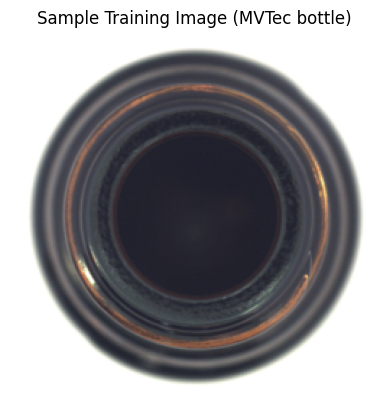


Initializing models...
ViT with DyT and GMDN initialized.
Loading model from /content/drive/MyDrive/Colab Notebooks/Computer Vision/trained_models...
=> Loading checkpoint


In [ ]:
# ==============================================================================
# Main script execution
# ==============================================================================
if not COMPARE_MODELS:
    print(f"Using device: {DEVICE}")
    # --- 1. Dataset and DataLoader ---
    print("Setting up datasets and dataloaders...")
    # Example for MVTec DATASET_CAT_STR.lower() category
    # Ensure MVTEC_DATA_DIR points to the root of the MVTec AD dataset
    # and contains a DATASET_CAT_STR.lower() subdirectory.
    try:
        if USING_MVTEC:
          train_dataset = MVTecDataset(
              data_dir=MVTEC_DATA_DIR, category=DATASET_CAT_STR.lower(),
              split="train", img_size=IMG_SIZE
          )
          test_dataset = MVTecDataset(
              data_dir=MVTEC_DATA_DIR, category=DATASET_CAT_STR.lower(),
              split="test", img_size=IMG_SIZE
          )
        else:
          train_dataset = BTADDataset(
            data_dir=BTAD_DATA_DIR, category=DATASET_CAT_STR.lower(),
            split="train", img_size=IMG_SIZE
          )
          test_dataset = BTADDataset(
              data_dir=BTAD_DATA_DIR, category=DATASET_CAT_STR.lower(),
              split="test", img_size=IMG_SIZE
          )

        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **NUM_WORKERS_PARAM)
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, **NUM_WORKERS_PARAM)

        # Show a sample training image
        if len(train_dataset) > 0:
            sample_train_img = next(iter(train_dataloader))
            Utils.show_image(sample_train_img[0], title=f"Sample Training Image (MVTec {DATASET_CAT_STR})")

    except Exception as e:
        print(f"Error setting up MVTec Dataloader: {e}")
        print("Please ensure the MVTec AD dataset is downloaded and extracted correctly,")
        print(f"and MVTEC_DATA_DIR ('{MVTEC_DATA_DIR}') points to its root directory.")
        print("Expected structure: MVTEC_DATA_DIR/category_name/train/good/..., MVTEC_DATA_DIR/category_name/test/...")
        train_dataloader = None # Prevent further errors
        test_dataloader = None


    # --- 2. Model Initialization ---
    print("\nInitializing models...")

    model = ViTAnomalyModelWithGMDN(
          img_size=IMG_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM,
          encoder_depth=NUM_LAYERS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
          norm_layer_type=CONF_STR.lower(), dyt_init_a=DYT_INIT_A, num_gaussians_gmdn=NUM_GAUSSIANS
      ).to(DEVICE)

    if not USING_DYT:
      model.gradient_checkpointing_enable()

    print(f"ViT with {CONF_STR} and GMDN initialized.")

    torch.cuda.empty_cache()

    # --- 3. Optimizer ---
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    wandb.summary["optimizer"] = optimizer.__class__.__name__
    losses = list()
    losses_gmdn = list()

    # --- 4. Training Loop ---
    if train_dataloader and TRAIN_MODEL: # Only train if data is loaded
        print(f"\nStarting training for ViT-{CONF_STR} model...")

        for epoch in range(NUM_EPOCHS): # A few epochs for demonstration
            loss_vec = train_one_epoch(model, train_dataloader, optimizer, epoch, NUM_EPOCHS)
            loss = np.array(loss_vec).mean()
            losses.append(loss)

            #TODO Add validation step here if you have a validation set of normal images, and add score to wandb
            wandb.log({"loss": loss})

            if epoch % 25 == 0: # Save every 25 epochs
                Utils.save_checkpoint({
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }, filename= os.path.join(MODEL_SAVE_DIR, f"vit_{CONF_STR.lower()}_epoch_training_{epoch}_{EXPERIMENT_NAME}_db_{DATASET_STR.lower()}.pth.tar"))


        #show loss plot
        Utils.plot_loss(losses, len(losses), title=f"ViT-{CONF_STR} Training Loss")

        # Save the model
        Utils.save_checkpoint({
            'epoch': NUM_EPOCHS,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, filename= os.path.join(MODEL_SAVE_DIR, FILENAME_STR))
        print(f"Training for ViT-{CONF_STR} finished.")
    else:
        print(f"Loading model from {MODEL_SAVE_DIR}...")
        Utils.load_checkpoint(os.path.join(MODEL_SAVE_DIR, f"vit_dyt_epoch_training_100_ethereal-planet-7.pth.tar"), model)



 Starting evaluation for ViT-DyT model ({'FIXED_THRESHOLD': False, 'FLIP': False})...
Evaluation completed. Number of image scores: 83
Shape of concatenated pixel scores: (83, 256, 256)
Shape of concatenated GT masks: (83, 256, 256)
Image-level AUROC: 0.5437
Image-level AUPR: 0.8295
Pixel-level AUROC: 0.8063
Pixel-level AUPR: 0.1737
PRO Score: 0.7273


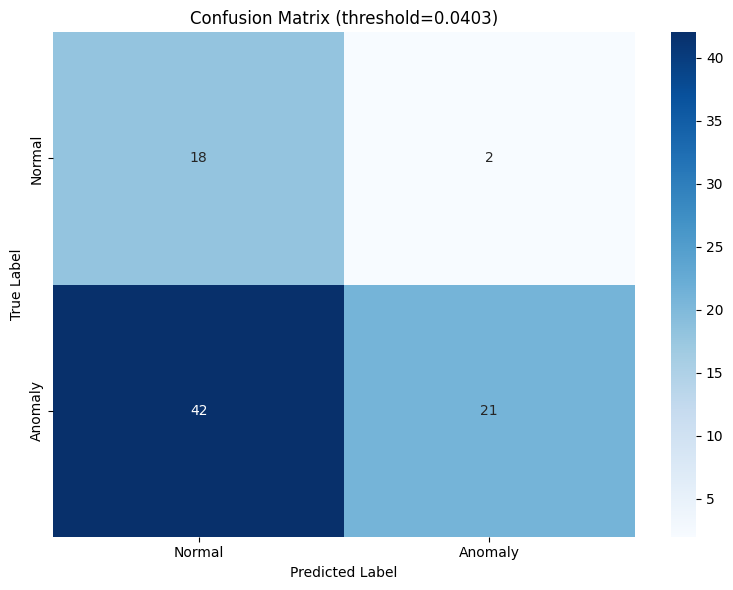


Classification Report:
              precision    recall  f1-score   support

      Normal       0.30      0.90      0.45        20
     Anomaly       0.91      0.33      0.49        63

    accuracy                           0.47        83
   macro avg       0.61      0.62      0.47        83
weighted avg       0.77      0.47      0.48        83



<Figure size 640x480 with 0 Axes>

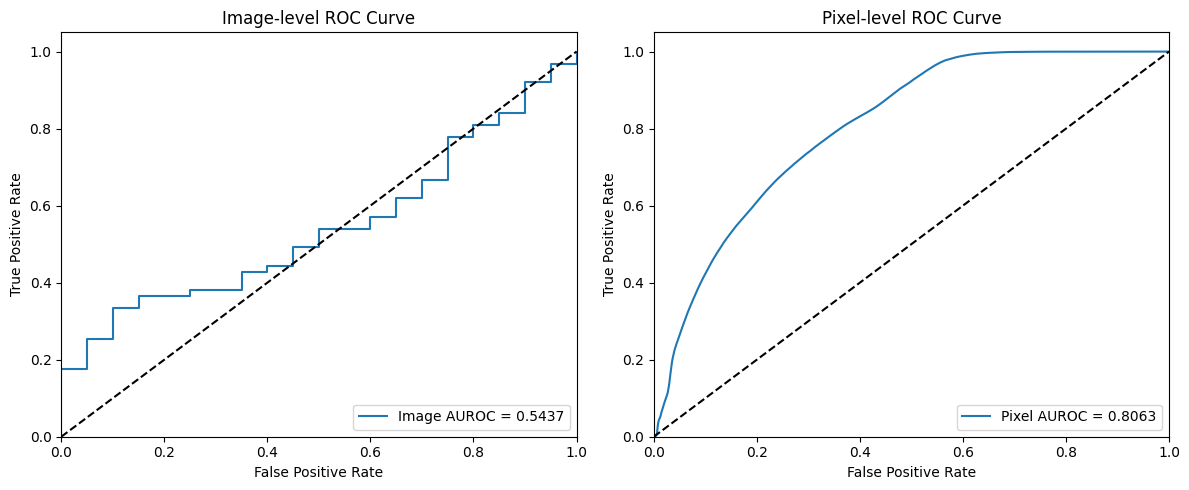

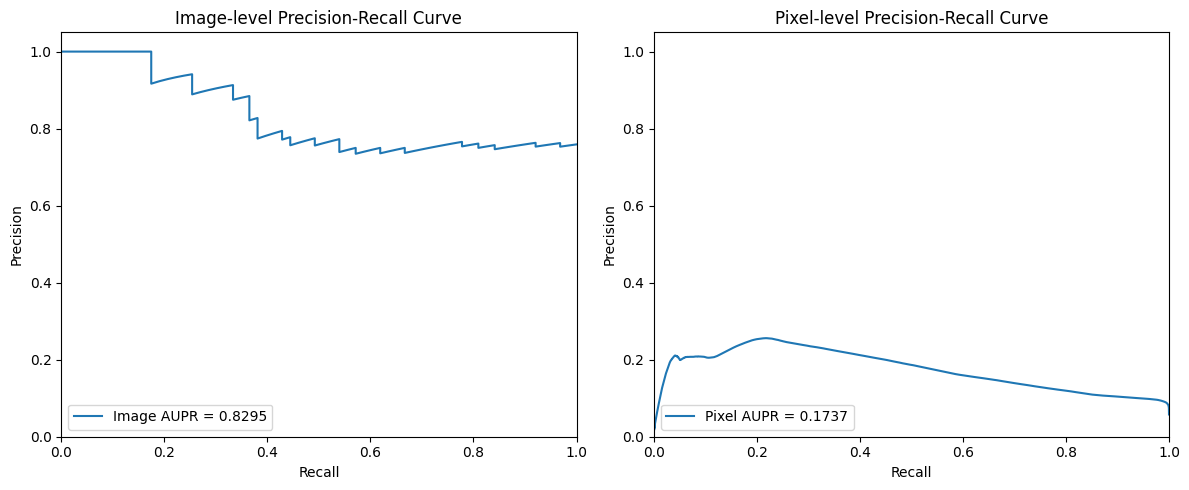

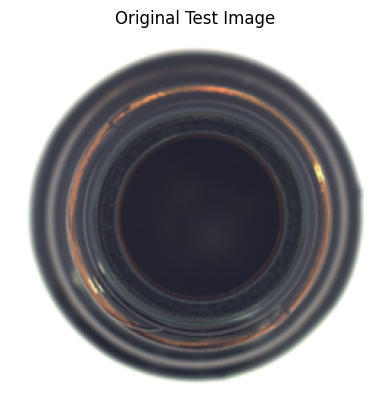

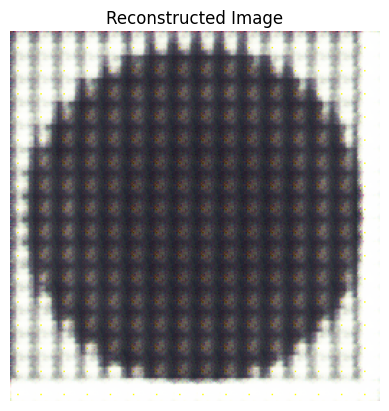

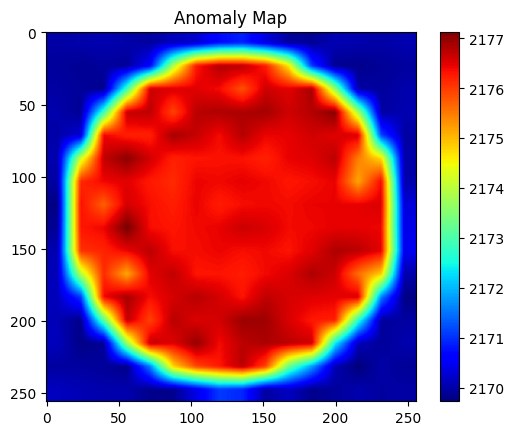

ViT-DyT Evaluation Results: {'img_auroc': np.float64(0.5436507936507936), 'img_aupr': np.float64(0.8294709254380954), 'pixel_auroc': np.float64(0.8062531154618304), 'pixel_aupr': np.float64(0.17369186340503878), 'pro_score': np.float64(0.7273208570103202)}

Project script finished.


In [ ]:
# ==============================================================================
# Evaluation on Test Set of the Trained Model
# ==============================================================================

if not COMPARE_MODELS:
    if test_dataloader: # Only evaluate if data is loaded
        # Load best checkpoint before evaluation if saved
        # Utils.load_checkpoint("best_vit_{CONF_STR.lower()}_model.pth.tar", model_vit)

        evaluation_params = {
            'FIXED_THRESHOLD': False,
            'FLIP': False
        }

        print(f"\n Starting evaluation for ViT-{CONF_STR} model ({evaluation_params})...")

        results = evaluate_model(model, test_dataloader, **evaluation_params)
        print(f"ViT-{CONF_STR} Evaluation Results: {results}")

        for key, value in results.items():
            wandb.summary[key] = value
    else:
        print("\nSkipping evaluation due to dataloader issues.")

    print("\nProject script finished.")
    wandb.finish()

## TODO

- Fare il codice in modo che prenda i file e faccia solo evaluation
- Poter ristartare il training da un modello già salvato (per fine tunare)
- Scrivere blocchi di codice che valutano le performance con e senza Dynamic Tanh

## Comparison between Different Models

In [ ]:
if COMPARE_MODELS:
    print("Comparing models...")    
    wandb.init(
        project="CV_project",
        name="Compare_Models"
    )    

    # TODO se non esplode qui forse si può eliminare roba inutile
    model_dyt_mvtec = ViTAnomalyModelWithGMDN(
        img_size=IMG_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM,
        encoder_depth=NUM_LAYERS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
        norm_layer_type="dyt", dyt_init_a=DYT_INIT_A, num_gaussians_gmdn=NUM_GAUSSIANS
    )

    model_ln_mvtec = ViTAnomalyModelWithGMDN(
        img_size=IMG_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM,
        encoder_depth=NUM_LAYERS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
        norm_layer_type="layernorm", dyt_init_a=DYT_INIT_A, num_gaussians_gmdn=NUM_GAUSSIANS
    )

    model_dyt_btad = ViTAnomalyModelWithGMDN(
        img_size=IMG_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM,
        encoder_depth=NUM_LAYERS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
        norm_layer_type="dyt", dyt_init_a=DYT_INIT_A, num_gaussians_gmdn=NUM_GAUSSIANS
    )

    model_ln_btad = ViTAnomalyModelWithGMDN(
        img_size=IMG_SIZE, patch_size=PATCH_SIZE, embed_dim=EMBED_DIM,
        encoder_depth=NUM_LAYERS, num_heads=NUM_HEADS, mlp_ratio=MLP_RATIO,
        norm_layer_type="layernorm", dyt_init_a=DYT_INIT_A, num_gaussians_gmdn=NUM_GAUSSIANS
    )

    models_dict = {
        DYT_MODEL_NAME_MVTEC: model_dyt_mvtec, 
        LN_MODEL_NAME_MVTEC: model_ln_mvtec, 
        DYT_MODEL_NAME_BTAD: model_dyt_btad, 
        LN_MODEL_NAME_BTAD: model_ln_btad
    }


    mvtec_test_dataset = MVTecDataset(
        data_dir=MVTEC_DATA_DIR, category=DATASET_CAT_STR.lower(),
        split="test", img_size=IMG_SIZE
    )
    btad_test_dataset = BTADDataset(
        data_dir=BTAD_DATA_DIR, category=DATASET_CAT_STR.lower(),
        split="test", img_size=IMG_SIZE
    )

    mvtec_test_dataloader = DataLoader(mvtec_test_dataset, batch_size=BATCH_SIZE, shuffle=False, **NUM_WORKERS_PARAM)
    btad_test_dataloader = DataLoader(btad_test_dataset, batch_size=BATCH_SIZE, shuffle=False, **NUM_WORKERS_PARAM)

    results = dict()

    for name, model in models_dict.items():
        
        model.to(DEVICE)
        Utils.load_checkpoint(os.path.join(MODEL_SAVE_DIR, name), model)

        time_start = time.time()

        if "mvtec" in name:
            result = evaluate_model(model, mvtec_test_dataloader)
        else:
            result = evaluate_model(model, btad_test_dataloader)
        
        time_end = time.time()

        print(f"{name} Evaluation Results: {result}")
        print(f"Model {name} took {time_end - time_start} seconds to evaluate")

        result["evaluation_time"] = time_end - time_start
        results[name] = result

        for key, value in result.items():
            wandb.summary[name + "_" + key] = value

        # Clear GPU memory
        del model
        torch.cuda.empty_cache()
    
    fig = Utils.visualize_model_results(results)
    wandb.summary["Model_Comparison"] = wandb.Image(fig)
    wandb.finish()

In [ ]:
# TODO controllare se funziona poi farlo brillare
def create_example_results():
    """
    Create an example results dictionary for demonstration.
    
    Returns:
    --------
    dict
        Example results dictionary
    """
    results = {
        "mvtec_resnet18": {
            "auroc": 0.923,
            "ap": 0.856,
            "f1_score": 0.789,
            "precision": 0.831,
            "recall": 0.752,
            "evaluation_time": 45.67
        },
        "mvtec_efficientnet": {
            "auroc": 0.945,
            "ap": 0.872,
            "f1_score": 0.802,
            "precision": 0.845,
            "recall": 0.764,
            "evaluation_time": 67.89
        },
        "mvtec_vit": {
            "auroc": 0.957,
            "ap": 0.891,
            "f1_score": 0.834,
            "precision": 0.867,
            "recall": 0.803,
            "evaluation_time": 120.45
        },
        "btad_resnet18": {
            "auroc": 0.887,
            "ap": 0.812,
            "f1_score": 0.743,
            "precision": 0.795,
            "recall": 0.698,
            "evaluation_time": 38.21
        },
        "btad_efficientnet": {
            "auroc": 0.912,
            "ap": 0.843,
            "f1_score": 0.775,
            "precision": 0.822,
            "recall": 0.734,
            "evaluation_time": 58.32
        },
        "btad_vit": {
            "auroc": 0.934,
            "ap": 0.865,
            "f1_score": 0.803,
            "precision": 0.851,
            "recall": 0.760,
            "evaluation_time": 110.78
        }
    }
    return results

# Example usage
if __name__ == "__main__":
    # Create example results
    results = create_example_results()
    
    # Generate visualization
    fig = Utils.visualize_model_results(results)
    
    # Save the figure
    fig.show()
    
    # If you want to display it (e.g., in a notebook)
    # plt.show()
    
    print("Visualization created and saved to 'model_evaluation_results.png'")